# HH Sensitivities


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import myokit

model = myokit.parse_model('''
[[model]]
ikr.a = 0
ikr.r = 1

[engine]
time = 0 bind time

[membrane]
V = 40
    desc: membane potential
    in [mV]

[nernst]
EK = -85 [mV]

[ikr]
use membrane.V
IKr = g * a * r * (V - nernst.EK)
dot(a) = (inf - a) / tau
    inf = k1 * tau
    tau = 1 / (k1 + k2)
    k1 = p1 * exp(p2 * V)
    k2 = p3 * exp(-p4 * V)
dot(r) = (inf - r) / tau
    inf = k4 * tau
    tau = 1 / (k3 + k4)
    k3 = p5 * exp(p6 * V)
    k4 = p7 * exp(-p8 * V)
p1 = 2.26e-4 [1/ms]
p2 = 0.0699 [1/mV]
p3 = 3.45e-5 [1/ms]
p4 = 0.05462 [1/mV]
p5 = 0.0873 [1/ms]
p6 = 8.91e-3 [1/mV]
p7 = 5.15e-3 [1/ms]
p8 = 0.03158 [1/mV]
p9 = 0.1524 [uS]
g = p9
''')

## Steady-state and time constant

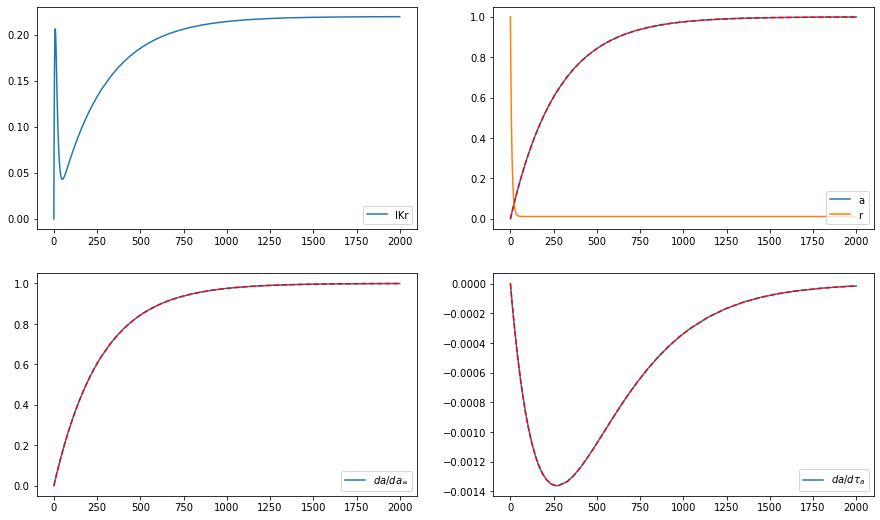

In [35]:
m = model.clone()
inf = m.get('ikr.a.inf')
tau = m.get('ikr.a.tau')
inf.set_rhs(inf.eval())
tau.set_rhs(tau.eval())

s = myokit.Simulation(m, sensitivities=[['ikr.a'], ['ikr.a.inf', 'ikr.a.tau']])

d, e = s.run(2000)
d = d.npview()
e = np.array(e)

a0 = m.get('ikr.a').state_value()
inf = inf.eval()
tau = tau.eval()

def f0(t):
    return inf - (inf - a0) * np.exp(-t / tau)

def f1(t):
    return 1 - np.exp(-t / tau)

def f2(t):
    return (a0 - inf) * (t / tau**2) * np.exp(-t / tau)
    

plt.figure(figsize=(15, 9))
plt.subplot(2, 2, 1)
plt.plot(d.time(), d['ikr.IKr'], label='IKr')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(d.time(), d['ikr.a'], label='a')
plt.plot(d.time(), d['ikr.r'], label='r')
plt.plot(d.time(), f0(d.time()), 'r--')
plt.legend(loc='lower right')
plt.subplot(2, 2, 3)
plt.plot(d.time(), e[:, 0, 0], label='$da/da_\infty$')
plt.plot(d.time(), f1(d.time()), 'r--')
plt.legend(loc='lower right')
plt.subplot(2, 2, 4)
plt.plot(d.time(), e[:, 0, 1], label='$da/d \\tau_a$')
plt.plot(d.time(), f2(d.time()), 'r--')
plt.legend()

plt.show()


## Rates

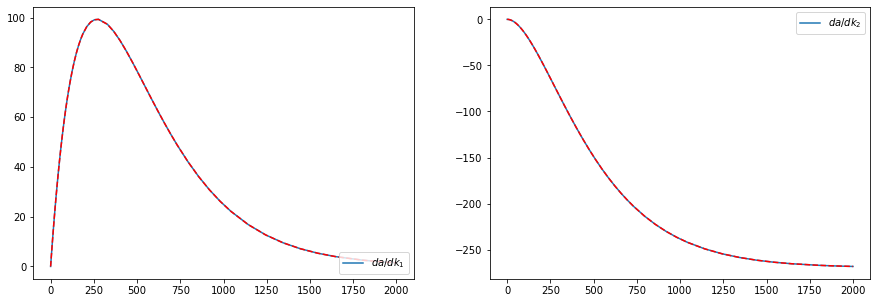

In [52]:
m = model.clone()
k1 = m.get('ikr.a.k1')
k2 = m.get('ikr.a.k2')
k1.set_rhs(k1.eval())
k2.set_rhs(k2.eval())

s = myokit.Simulation(m, sensitivities=[['ikr.a'], ['ikr.a.k1', 'ikr.a.k2']])

d, e = s.run(2000)
d = d.npview()
e = np.array(e)


a0 = m.get('ikr.a').state_value()
k1 = k1.eval()
k2 = k2.eval()

def f1(t):
    return k2 / (k1 + k2)**2 - (k2/(k1+k2)**2 - k1 * t/(k1+k2) + a0*t) * np.exp(-(k1 + k2)*t)

def f2(t):
    return -k1 / (k1 + k2)**2 - (-k1/(k1+k2)**2 - k1 * t/(k1+k2) + a0*t) * np.exp(-(k1 + k2)*t)


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(d.time(), e[:, 0, 0], label='$da/dk_1$')
plt.plot(d.time(), f1(d.time()), 'r--')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(d.time(), e[:, 0, 1], label='$da/dk_2$')
plt.plot(d.time(), f2(d.time()), 'r--')
plt.legend()

plt.show()

## Parameters

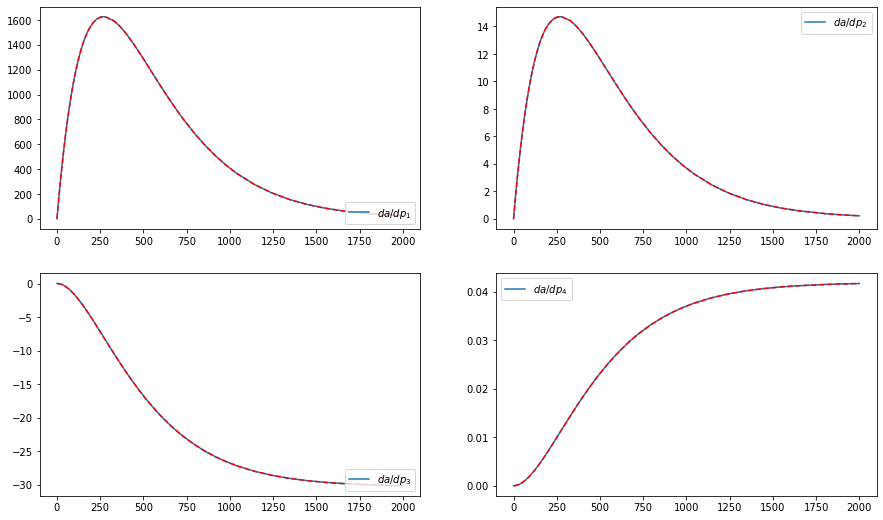

In [56]:
m = model.clone()
k1 = m.get('ikr.a.k1')
k2 = m.get('ikr.a.k2')
p1 = m.get('ikr.p1')
p2 = m.get('ikr.p2')
p3 = m.get('ikr.p3')
p4 = m.get('ikr.p4')

s = myokit.Simulation(m, sensitivities=[['ikr.a'], ['ikr.p1', 'ikr.p2', 'ikr.p3', 'ikr.p4']])

d, e = s.run(2000)
d = d.npview()
e = np.array(e)

V = m.get('membrane.V').eval()
a0 = m.get('ikr.a').state_value()
k1 = k1.eval()
k2 = k2.eval()
p1 = p1.eval()
p2 = p2.eval()
p3 = p3.eval()
p4 = p4.eval()

def f1(t):
    dadk1 = (k2 / (k1 + k2)**2 - (k2/(k1+k2)**2 - k1 * t/(k1+k2) + a0*t) * np.exp(-(k1 + k2)*t))
    return np.exp(p2 * V) * dadk1

def f2(t):
    dadk1 = (k2 / (k1 + k2)**2 - (k2/(k1+k2)**2 - k1 * t/(k1+k2) + a0*t) * np.exp(-(k1 + k2)*t))
    return p1 * V * np.exp(p2 * V) * dadk1

def f3(t):
    dadk2 = -k1 / (k1 + k2)**2 - (-k1/(k1+k2)**2 - k1 * t/(k1+k2) + a0*t) * np.exp(-(k1 + k2)*t)
    return np.exp(-p4 * V) * dadk2
    
def f4(t):
    dadk2 = -k1 / (k1 + k2)**2 - (-k1/(k1+k2)**2 - k1 * t/(k1+k2) + a0*t) * np.exp(-(k1 + k2)*t)
    return -p3 * V* np.exp(-p4 * V) * dadk2

plt.figure(figsize=(15, 9))

plt.subplot(2, 2, 1)
plt.plot(d.time(), e[:, 0, 0], label='$da/dp_1$')
plt.plot(d.time(), f1(d.time()), 'r--')
plt.legend(loc='lower right')
plt.subplot(2, 2, 2)
plt.plot(d.time(), e[:, 0, 1], label='$da/dp_2$')
plt.plot(d.time(), f2(d.time()), 'r--')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(d.time(), e[:, 0, 2], label='$da/dp_3$')
plt.plot(d.time(), f3(d.time()), 'r--')
plt.legend(loc='lower right')
plt.subplot(2, 2, 4)
plt.plot(d.time(), e[:, 0, 3], label='$da/dp_4$')
plt.plot(d.time(), f4(d.time()), 'r--')
plt.legend()

plt.show()